In [1]:
# importing needed libraries for the naive bayes implementation based on methods used from sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import confusion_matrix, precision_score, ConfusionMatrixDisplay

In [2]:
# reading the datafile in as a pandas dataframe
data2 = pd.read_csv("emails_copy.csv")

# for my implementation, I had to convert the dataframe to a numpy ndarray, as the pandas dataframe 
# originally has a header that would cause problems, I attempted to read the csv with header = none,
# but this just removed the names associated with the columns and not the header itself.
inputDf2 = data2.to_numpy()

# I saved the column containing the labels to a variable to use as my class labels
lableData2 = inputDf2[:,-1]

# I removed the first column containing the numbers of the email(ex. "Email 1, Email 2, ... Email n") 
# which was not needed and the last column containing the labels, which were previously saved to a 
# variable
inputDf2 = np.delete(inputDf2, 0, axis=1)
inputDf2 = np.delete(inputDf2, -1, axis=1)

# Converted the whole data frame from int values to float values, this was because there were issues
# with one of the numpy functions requiring a float
inputDf2.astype(np.float64)

# Last modification to the dataset was adding 1 or 2 to every row. This dataset contained a lot of 0
# values for features included in the entries. Originally I had accounted for this by adding 1 to 
# the whole dataset, which was fine when using the "off-the-shelf" implementation, but for my naive
# bayes using the gaussian probabilty density function it created variance values of 0 which caused
# issues when calculating the posteriors. To make the variance non-zero I added alternating 1's 
# and 2's which fixed for zero-frequency and was small enough to not affect the results.
for i in range(3000):
    if i % 2 == 0:
        inputDf2[i] += 2
    else:
        inputDf2[i] += 1



In [3]:
# Using the sklearn.modelselection module to split the data for me
X_train2, X_test2, y_train2, y_test2 = train_test_split(inputDf2, lableData2, test_size=0.25, random_state=9)

In [4]:
# Created a function to fit the model
def fit(trainFeatures, trainLabels):
    # Getting needed values from dataset including counting the # samples, # features, # classes
    # and create a list of classes
    nSamples, nFeatures = trainFeatures.shape
    listOfClasses = np.unique(trainLabels)
    nClasses = len(listOfClasses)

    # Using np.zeros to create empty ndarrys to hold the values for the means, variance and 
    # priors of each feature in the dataset 
    means = np.zeros((nClasses, nFeatures), dtype=np.float64)
    vars = np.zeros((nClasses, nFeatures), dtype=np.float64)
    priors = np.zeros(nClasses, dtype=np.float64)

    # many references break up finding the values above so I followed the same format, because
    # we have a ndarry I could use np.mean/var with axis=0 to apply the function along the column
    # calculating the priors for the classes was simple as well, when creating the later predict
    # function I added the return values so that i could call this fit function from within the
    # next function.
    for ind, classes in enumerate(listOfClasses):
        C = trainFeatures[trainLabels == classes]
        means[ind, :] = C.mean(axis=0)
        vars[ind, :] = C.var(axis=0)
        priors[ind] = (C.shape[0] / float(nSamples))
    return(means, vars, priors)

In [5]:
def fitMN(trainFeatures, trainLabels):
    # computing priors
    nSamples, nFeatures = trainFeatures.shape
    listOfClasses = np.unique(trainLabels)
    nClasses = len(listOfClasses)
    
    # creating ndarrays exactly how i did for the gaussian distribution but only needed two for the priors and likelyhoods
    priors = np.zeros(nClasses, dtype=np.float64)
    likelyhood = np.zeros((nClasses, nFeatures), dtype=np.float64)
    a = 1

    for ind, classes in enumerate(listOfClasses):
        C = trainFeatures[trainLabels == classes]
        # finding the posterial probably 
        #likelyhood[ind, :] = (trainFeatures.sum(axis=0) + a) / (tempsum + a)
        likelyhood[ind, :] = (C.sum(axis=0) + a) / (np.sum(C.sum(axis=0)) + a)
        priors[ind] = (C.shape[0] / float(nSamples))
    return(likelyhood, priors)

In [6]:
def predict(trainFeatures, trainLabels, testFeatures):
    # Calling my fit function and getting a list of the classes
    means, vars, priors = fit(trainFeatures, trainLabels)
    listOfClasses = np.unique(trainLabels)

    def pdf_gaus (index, x):
        mean = means[index]
        var = vars[index]
     
        # had a lot of issues with this part of my implementation, the formula for the guassian 
        # density function, I fixed the issue with having columns with 0 variance early on, 
        # this caused the right side of the PDF to have a denominator = 0 for some values which
        # caused erros. Once this was fixed, the np.exp function required datatypes of float,
        # even though I converted the values of the ndarray to float when I imported the data
        # set, I found the only way to get around this was to convert the value being passed
        # to np.exp astype np.float64
        return (1 / np.sqrt(2 * np.pi * var)) * (np.exp((-((x - mean) ** 2) / (2 * var)).astype(np.float64)))

    def pred (x):
        posteriors = []
        for ind, classes in enumerate(listOfClasses):
            # Using the enumerate on the value returned by np.unique allowed me to iterate for each class,
            # in my case it was only two (0,1), but because we used the unique call, this had the side 
            # effect of extending to more classes although this was not tested, should not have any issues. 
            # calculating priors based on classes [0,1]
            prior = np.log(priors[ind])
            posterior = np.sum(np.log(pdf_gaus(ind, x)))
            # calculating the posterior likelyhood P(c|Xi)
            posterior = posterior + prior
            posteriors.append(posterior)
        return(listOfClasses[np.argmax(posteriors)])

    yPredictions = [pred(x) for x in testFeatures]      
    return np.array(yPredictions)

In [7]:
def predictMN(trainFeatures, trainLabels, testFeatures):
    likelihoods, priors = fitMN(trainFeatures, trainLabels)
    listOfClasses = np.unique(trainLabels)

    def likelihoodEst(l, x):
        return np.log(l) * x
    
    def pred(x):
        posteriors = []
        for ind, c in enumerate(listOfClasses):
            prior = np.log(priors[ind])
            classLikelihood = likelihoodEst(likelihoods[ind,:], x)
            postClass = np.sum(classLikelihood) + prior
            posteriors.append(postClass)

        return listOfClasses[np.argmax(posteriors)]
    predictions = [pred(x) for x in testFeatures]

    return np.array(predictions)

In [8]:
# Calling my predict functions, (it finally ran with no problems yay)
gausPredicts = predict(X_train2, y_train2, X_test2)
MNPredicts = predictMN(X_train2, y_train2, X_test2)

/var/folders/wh/svmnsqtn1mddnm136klzmggh0000gn/T/ipykernel_12655/3313821754.py:27: RuntimeWarning: divide by zero encountered in log
  posterior = np.sum(np.log(pdf_gaus(ind, x)))


In [9]:
def naiveBMetrics (yTrueValues, yPreds):
    predPos = (yPreds == 1)
    predNeg = (yPreds == 0)

    testPos = (y_test2 == 1)
    testNeg = (y_test2 == 0)

    truePosIndex = np.where(yTrueValues == 1)
    trueNegIndex = np.where(yTrueValues == 0)
    TN = 0; TP = 0; FP = 0; FN = 0
    
    # Counting TP
    for a in truePosIndex:
        TP = np.sum(predPos[a])

    # Counting TN
    for b in trueNegIndex:
        TN = np.sum(predNeg[b])

    # Counting FP
    for c in trueNegIndex:
        FP = np.sum(predPos[c])

    # Counting FN
    for d in truePosIndex:
        FN = np.sum(predNeg[d])
        
    prec = (TP / (TP + FP)) 
    rec = (TP / (TP + FN)) 
   
    f1 = (2 * (prec * rec)) / (prec + rec)
    
    return ('True Pos:' , TP ,'True Neg:', TN ,'False Pos:' ,FP ,'False Neg:' ,FN ,'Precision:', prec ,'Recall:', rec,'F1 Score:', f1)

In [10]:
gausMetrics = naiveBMetrics(y_test2, gausPredicts)
MNmetrics = naiveBMetrics(y_test2, MNPredicts)

In [11]:
print(gausMetrics)
print(MNmetrics)

('True Pos:', 74, 'True Neg:', 875, 'False Pos:', 37, 'False Neg:', 307, 'Precision:', 0.6666666666666666, 'Recall:', 0.1942257217847769, 'F1 Score:', 0.30081300813008127)
('True Pos:', 212, 'True Neg:', 478, 'False Pos:', 434, 'False Neg:', 169, 'Precision:', 0.3281733746130031, 'Recall:', 0.5564304461942258, 'F1 Score:', 0.41285296981499514)


AVERAGING PERFORMANCE OF MODELS

In [12]:
# because I did not create a class that would allow me to use sklearn's cross validation functions, I ran my classifier 
# multiple times and took averages of the metrics, removed the random state so it would be random each time called and 
# lowered the test size to 20%
xtrain1, xtest1, ytrain1, ytest1 = train_test_split(inputDf2, lableData2, test_size=0.20)
xtrain2, xtest2, ytrain2, ytest2 = train_test_split(inputDf2, lableData2, test_size=0.20)
xtrain3, xtest3, ytrain3, ytest3 = train_test_split(inputDf2, lableData2, test_size=0.20)
xtrain4, xtest4, ytrain4, ytest4 = train_test_split(inputDf2, lableData2, test_size=0.20)
xtrain5, xtest5, ytrain5, ytest5 = train_test_split(inputDf2, lableData2, test_size=0.20)

In [13]:
# Generating predictions based on the newly shuffled data for both the gausian/multinomial models
gausPred1 = predict(xtrain1, ytrain1, xtest1)
gausPred2 = predict(xtrain2, ytrain2, xtest2)
gausPred3 = predict(xtrain3, ytrain3, xtest3)
gausPred4 = predict(xtrain4, ytrain4, xtest4)
gausPred5 = predict(xtrain5, ytrain5, xtest5)

mnPred1 = predictMN(xtrain1, ytrain1, xtest1)
mnPred2 = predictMN(xtrain2, ytrain2, xtest2)
mnPred3 = predictMN(xtrain3, ytrain3, xtest3)
mnPred4 = predictMN(xtrain4, ytrain4, xtest4)
mnPred5 = predictMN(xtrain5, ytrain5, xtest5)


/var/folders/wh/svmnsqtn1mddnm136klzmggh0000gn/T/ipykernel_12655/3313821754.py:27: RuntimeWarning: divide by zero encountered in log
  posterior = np.sum(np.log(pdf_gaus(ind, x)))


In [14]:
# generating metrics based on my predictions on test data for both types of models
gausAvgMetrics1 = naiveBMetrics(ytest1, gausPred1)
gausAvgMetrics2 = naiveBMetrics(ytest2, gausPred2)
gausAvgMetrics3 = naiveBMetrics(ytest3, gausPred3)
gausAvgMetrics4 = naiveBMetrics(ytest4, gausPred4)
gausAvgMetrics5 = naiveBMetrics(ytest5, gausPred5)

mNAvgMetrics1 = naiveBMetrics(ytest1, mnPred1)
mNAvgMetrics2 = naiveBMetrics(ytest2, mnPred2)
mNAvgMetrics3 = naiveBMetrics(ytest3, mnPred3)
mNAvgMetrics4 = naiveBMetrics(ytest4, mnPred4)
mNAvgMetrics5 = naiveBMetrics(ytest5, mnPred5)

In [15]:
# average values of gaussian
print("avg Gaussian NB Precision:", ((gausAvgMetrics1[9] + gausAvgMetrics2[9] + gausAvgMetrics3[9] + gausAvgMetrics4[9] + gausAvgMetrics5[9]) / 5))
print("avg Gaussian NB Recall:", ((gausAvgMetrics1[11] + gausAvgMetrics2[11] + gausAvgMetrics3[11] + gausAvgMetrics4[11] + gausAvgMetrics5[11]) / 5))
print("avg. Gaussian NB F1 score:", ((gausAvgMetrics1[13] + gausAvgMetrics2[13] + gausAvgMetrics3[13] + gausAvgMetrics4[13] + gausAvgMetrics5[13]) / 5))

# average values of multinomial
print("avg Gaussian Multinomial Precision:", ((mNAvgMetrics1[9] + mNAvgMetrics2[9] + mNAvgMetrics3[9] + mNAvgMetrics4[9] + mNAvgMetrics5[9]) / 5))
print("avg Gaussian Multinomial Recall:", ((mNAvgMetrics1[11] + mNAvgMetrics2[11] + mNAvgMetrics3[11] + mNAvgMetrics4[11] + mNAvgMetrics5[11]) / 5))
print("avg Gaussian Multinomial F1 Score:", ((mNAvgMetrics1[13] + mNAvgMetrics2[13] + mNAvgMetrics3[13] + mNAvgMetrics4[13] + mNAvgMetrics5[13]) / 5))

avg Gaussian NB Precision: 0.5406193139700336
avg Gaussian NB Recall: 0.3972444513487609
avg. Gaussian NB F1 score: 0.41185786191815155
avg Gaussian Multinomial Precision: 0.31998514509212567
avg Gaussian Multinomial Recall: 0.5639114788677977
avg Gaussian Multinomial F1 Score: 0.4082144607718921


Below I am generating the graphs used in my report with the generated data

<AxesSubplot:title={'center':'Distribution of counts of words in dataset'}, xlabel='Index', ylabel='Freuency'>

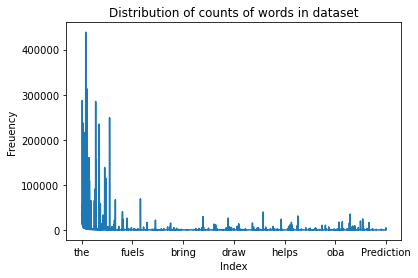

In [17]:
# summing the counts of words to plot
df2 = data2 
histdata = df2.sum(axis=0)[1:]
# creating a histogram of my dataset to see distribution of words
histdata.plot(title="Distribution of counts of words in dataset", xlabel="Index", ylabel="Freuency")


[0.31931166 0.32375479 0.32617188 0.31153846 0.31914894]


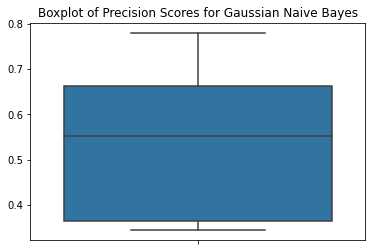

In [18]:
# putting the values into arrays so that they can be input into a graph
valuesForGausPrec = np.array([gausAvgMetrics1[9] , gausAvgMetrics2[9] , gausAvgMetrics3[9] ,gausAvgMetrics4[9] , gausAvgMetrics5[9]])
valuesForMPrec = np.array([mNAvgMetrics1[9], mNAvgMetrics2[9],  mNAvgMetrics3[9],  mNAvgMetrics4[9],  mNAvgMetrics5[9]])
sns.boxplot(y = valuesForGausPrec).set(title="Boxplot of Precision Scores for Gaussian Naive Bayes")



[Text(0.5, 1.0, 'Boxplot of Precision Scores for Multinomial Naive Bayes')]

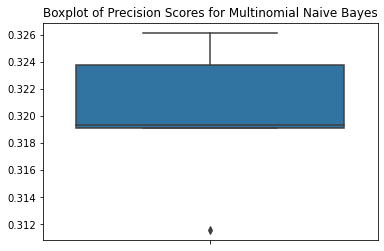

In [19]:
sns.boxplot(y = valuesForMPrec).set(title="Boxplot of Precision Scores for Multinomial Naive Bayes")

[Text(0.5, 1.0, 'Boxplot of F1 Scores for Gaussian Naive Bayes')]

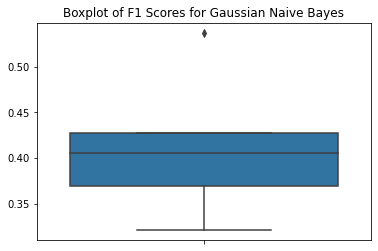

In [20]:
# values for my  F1 
valuesForGausF1 = np.array([gausAvgMetrics1[13], gausAvgMetrics2[13], gausAvgMetrics3[13], gausAvgMetrics4[13], gausAvgMetrics5[13]])
valuesForMF1 = np.array([mNAvgMetrics1[13], mNAvgMetrics2[13] , mNAvgMetrics3[13] , mNAvgMetrics4[13] , mNAvgMetrics5[13]])
# plotting my values for F1
sns.boxplot(y=valuesForGausF1).set(title="Boxplot of F1 Scores for Gaussian Naive Bayes")

[Text(0.5, 1.0, 'Boxplot of F1 Scores for Multinomial Naive Bayes')]

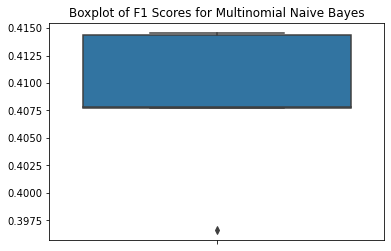

In [21]:
sns.boxplot(y=valuesForMF1).set(title="Boxplot of F1 Scores for Multinomial Naive Bayes")


In [25]:
# print(np.sum(valuesForGausPrec) / 5)
# print(np.sum(valuesForMPrec)/5)
# print(np.sum(valuesForGausF1)/5)
# print(np.sum(valuesForMF1)/5)
print(np.std(valuesForGausPrec))
print(np.std(valuesForMPrec))
print(np.std(valuesForGausF1))
print(np.std(valuesForMF1))

0.1686641874844626
0.0049997025930525
0.07234114057139975
0.006550176184839461
